# DSCI 419: Deep Learning
# Project 4
### Lauren Forti
### 04/03/2023

Convolutional neural networks are built to classify images of beans for disease.

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
from IPython.display import display
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models

In [2]:
# mute tf warnings 
import logging
tf.get_logger().setLevel(logging.ERROR)

## Part 1: Load the data
The dataset is downloaded to the local directory. Labels are extracted and several images from the dataset are displayed.

In [3]:
# load dataset to directory
beans_url = 'https://storage.googleapis.com/ibeans/train.zip'
img_dir = tf.keras.utils.get_file('beans',
                                  origin = beans_url,
                                  archive_format = 'zip',
                                  extract = True
                                 )

# correct directory path
img_dir = pathlib.Path(img_dir)
img_dir = img_dir.parent
img_dir = pathlib.Path(str(img_dir) + '\\train')

# output directory
print(f'The beans photes are stored in local directory : {img_dir}')

The beans photes are stored in local directory : C:\Users\laure\.keras\datasets\train


In [4]:
# look at # of files in dataset
total_files = 0
for root, dirs, files in os.walk(str(img_dir)):
    level = root.replace(str(img_dir), '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/ ({len(files)} files)')
    total_files += len(files)

# output # of files
print(f'There are {total_files -1} images in this dataset')

train/ (0 files)
    angular_leaf_spot/ (345 files)
    bean_rust/ (348 files)
    healthy/ (342 files)
There are 1034 images in this dataset


In [5]:
# extract labels
beans_dir = [name for name in list(os.listdir(img_dir)) if os.path.isdir(os.path.join(img_dir, name))]

# output labels
print(f' The bean labels = {beans_dir}')

 The bean labels = ['angular_leaf_spot', 'bean_rust', 'healthy']


(Image size  = (500, 500, 3) ; Beans = angular_leaf_spot)


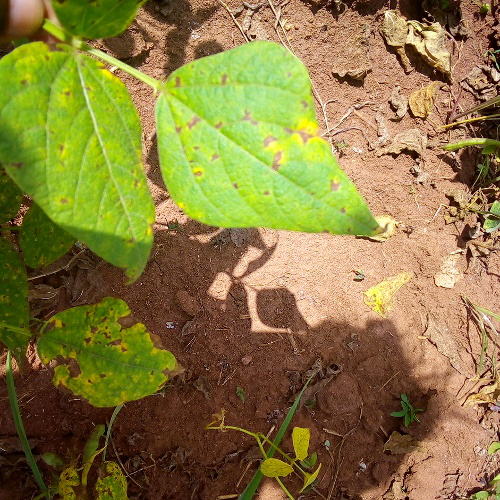

(Image size  = (500, 500, 3) ; Beans = bean_rust)


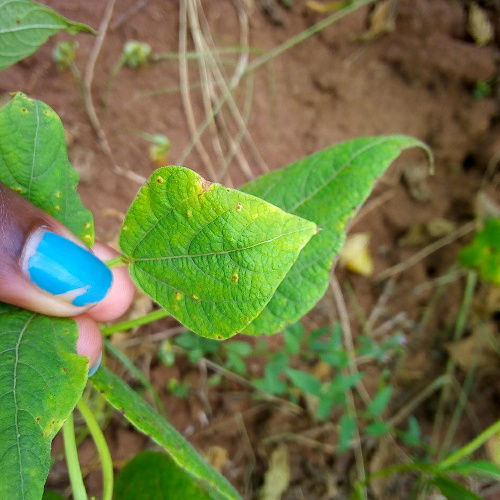

(Image size  = (500, 500, 3) ; Beans = healthy)


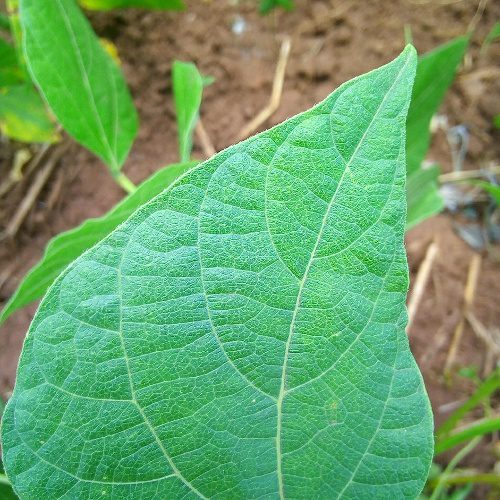

In [6]:
# display sample images of dataset

# set seed
SEED = 503
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(SEED)
tf.random.set_seed(SEED)

# display images
for i in range(len(beans_dir)):
   
    image_file = list(img_dir.glob(beans_dir[i]+'/*'))
    img = PIL.Image.open(str(image_file[0]))
    
    print(f'(Image size  = ({img.size[0]}, {img.size[0]}, {len(img.mode)}) ; Beans = {beans_dir[i]})')
    display(img)
   

## Part 2: Split the data into training and testing sets
The data is split into training and testing datasets.

In [48]:
# set params
batch_size = 32
train_test_split = 0.2
image_height = 500
image_width = 500

In [49]:
# create training df
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  labels = 'inferred',
  label_mode = 'int',
  validation_split = train_test_split,
  subset = "training",
  seed= 503,
  image_size = (image_height, image_width),
  batch_size = batch_size)

Found 1034 files belonging to 3 classes.
Using 828 files for training.


In [50]:
# create validation df
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  labels = 'inferred',
  label_mode = 'int',
  validation_split = train_test_split,
  subset = "validation",
  seed = 503,
  image_size = (image_height, image_width),
  batch_size = batch_size)

Found 1034 files belonging to 3 classes.
Using 206 files for validation.


## Part 3: CNN model
A CNN model is built with TensorFlow to perform image classification.

In [51]:
# get # of labels and channels
num_labels = len(beans_dir)
print(f'There are {num_labels} classes in the image dataset')
image_channel = 3
print(f' There are {image_channel} channels in the images')

# build model
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, image_channel)),
    
    # first convolution layer
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # second convolution layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # third convolution layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    # pooling window
    layers.MaxPooling2D(),

    # flatten
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(num_labels)
])

There are 3 classes in the image dataset
 There are 3 channels in the images


In [52]:
# get model summary
model.summary()

# output graphic summary
dot_img_file = 'cnnmodel.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes = True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 250, 250, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)     

In [53]:
# configure model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [54]:
%%time

# create callback
cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)
# set # of epochs
epochs = 12

# fit model
history = model.fit(
  train_data,
  validation_data = val_data,
  epochs = epochs,
  callbacks = [cb], verbose = 1
)

Epoch 1/12
26/26 [==============================] - 143s 5s/step - loss: 3.7883 - accuracy: 0.4215 - val_loss: 0.9071 - val_accuracy: 0.6456
Epoch 2/12
26/26 [==============================] - 124s 5s/step - loss: 0.8343 - accuracy: 0.6051 - val_loss: 0.7891 - val_accuracy: 0.6359
Epoch 3/12
26/26 [==============================] - 127s 5s/step - loss: 0.6582 - accuracy: 0.7174 - val_loss: 0.6819 - val_accuracy: 0.6650
Epoch 4/12
26/26 [==============================] - 126s 5s/step - loss: 0.4935 - accuracy: 0.7911 - val_loss: 0.6344 - val_accuracy: 0.7233
Epoch 5/12
26/26 [==============================] - 125s 5s/step - loss: 0.3907 - accuracy: 0.8587 - val_loss: 0.6077 - val_accuracy: 0.6990
Epoch 6/12
26/26 [==============================] - 125s 5s/step - loss: 0.2888 - accuracy: 0.8877 - val_loss: 0.9483 - val_accuracy: 0.6602
Epoch 7/12
26/26 [==============================] - 125s 5s/step - loss: 0.1777 - accuracy: 0.9312 - val_loss: 0.7077 - val_accuracy: 0.7039
Wall time: 14

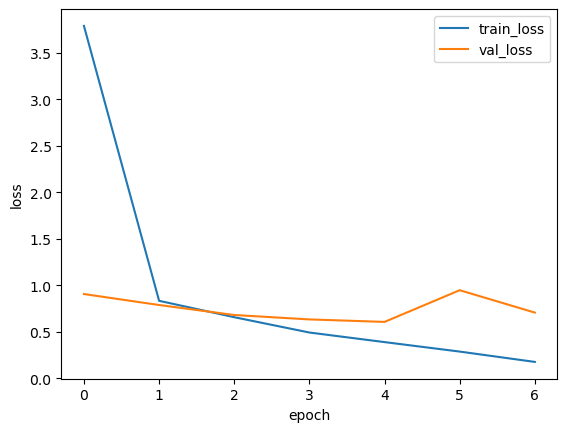

In [55]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

# plot train loss + validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history)
# add legends
plt.legend(labels = ['train_loss', 'val_loss'])

In [65]:
test_loss, test_acc = model.evaluate(val_data, verbose = 0)
print(f' The test loss = {test_loss:.2f} and test accuracy = {test_acc:.2f}')

 The test loss = 0.71 and test accuracy = 0.70


The first convolutional neural network overfits the model.

Training loss starts at around 4 and sharply decreases after 1 epoch. It continuously decreases with a negative slope.

Validation loss starts lower than training loss, at about 1. It crosses over training loss at around 2 epochs. Then it decreases up to the 4th epoch. It increases at the 5th epoch and then starts decreasing. 

The decreasing training loss and higher validation loss indicates that the model is overfit.

## Part 4: Data Augmentation
The CNN model is rebuilt with data augmentation techniques.

In [56]:
# transform images
data_aug = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape = (image_height, 
                                                              image_width,
                                                              image_channel)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor = 0.1,width_factor = 0.1 ),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (0.1, 0.1))
  ]
)

In [57]:
# build model w/ data aug
model2 = tf.keras.Sequential([
    # data augmentation
    data_aug,
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, image_channel)),
    
    # first convolution layer
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # second convolution layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    # pooling window
    layers.MaxPooling2D(),
  
    # third convolution layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    # pooling window
    layers.MaxPooling2D(),
    
    # flatten
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(num_labels)
])

In [58]:
# configure model
model2.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [59]:
# look at model structure
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 500, 500, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 250, 250, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                 

In [60]:
%%time

# train model
history2 = model2.fit(
  train_data,
  validation_data = val_data,
  epochs = epochs,
  callbacks = [cb], verbose = 1
)

Epoch 1/12
26/26 [==============================] - 189s 7s/step - loss: 6.2639 - accuracy: 0.3720 - val_loss: 1.0911 - val_accuracy: 0.2718
Epoch 2/12
26/26 [==============================] - 173s 7s/step - loss: 0.9925 - accuracy: 0.5169 - val_loss: 0.9683 - val_accuracy: 0.4757
Epoch 3/12
26/26 [==============================] - 173s 7s/step - loss: 0.9146 - accuracy: 0.5809 - val_loss: 0.8021 - val_accuracy: 0.6602
Epoch 4/12
26/26 [==============================] - 175s 7s/step - loss: 0.8040 - accuracy: 0.6329 - val_loss: 0.8149 - val_accuracy: 0.6893
Epoch 5/12
26/26 [==============================] - 195s 8s/step - loss: 0.8373 - accuracy: 0.6461 - val_loss: 0.8370 - val_accuracy: 0.6456
Epoch 6/12
26/26 [==============================] - 185s 7s/step - loss: 0.7686 - accuracy: 0.6836 - val_loss: 0.7737 - val_accuracy: 0.6650
Epoch 7/12
26/26 [==============================] - 184s 7s/step - loss: 0.6913 - accuracy: 0.7162 - val_loss: 0.7643 - val_accuracy: 0.6893
Wall time: 21

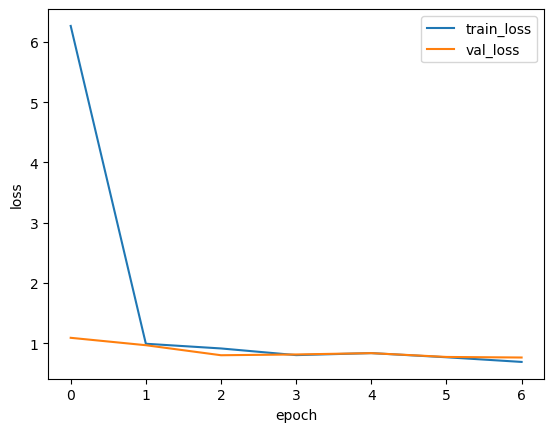

In [61]:
train_history2 = pd.DataFrame(history2.history)
train_history2['epoch'] = history2.epoch

# plot train loss + validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history2)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history2)
# add legends
plt.legend(labels = ['train_loss', 'val_loss'])

In [66]:
test_loss2, test_acc2 = model2.evaluate(val_data, verbose = 0)
print(f' The test loss = {test_loss2:.2f} and test accuracy = {test_acc2:.2f}')

 The test loss = 0.76 and test accuracy = 0.69


The second convolutional neural network does not perform better than the first model, but it is a better fit.
The test loss is slightly higher and the test accuracy is .01 below the first model's.

Training loss starts at around 6 and sharply decreases after 1 epoch to around 1. It then continuously decreases with a negative slope.

Validation loss starts lower than training loss, at about 1, and continually decreases. 

The decreasing training loss and validation loss indicates that the model is a decent fit, but there is room for improvement.

## Part 5: Pretrained Networks
A CNN model is built using transfer learning and TensorFlow.

In [68]:
# specify image size
IMG_SHAPE = (image_height, image_width, image_channel)

# pretrain on image net
MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

In [69]:
# freeze top layer
MobileNetV3Large_model.trainable = False

In [70]:
# preprocess data
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

# take a batch
image_batch, label_batch = next(iter(train_data))
feature_batch = MobileNetV3Large_model(image_batch)
# check size
print(feature_batch.shape)

# convert from 2D to 4D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# flatten
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 16, 16, 960)
(32, 960)
(32, 245760)


In [71]:
# add classification layer
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(f' The size of the predicted value for a given batch = {prediction_batch.shape}')

 The size of the predicted value for a given batch = (32, 3)


In [72]:
# create model
inputs = tf.keras.Input(shape = IMG_SHAPE)

x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

In [73]:
# set learning rate
learning_rate = 0.0001

# configure model
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [74]:
# look at model structure
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 500, 500, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 16, 16, 960)      2996352   
 l)                                                              
                                                                 
 flatten_7 (Flatten)         (None, 245760)            0         
                                                                 
 dropout (Dropout)           (None, 245760)            0         
                                                                 
 dense_14 (Dense)            (None, 3)                 737283    
                                                             

In [75]:
%%time

# train model
history3 = model3.fit(
  train_data,
  validation_data = val_data,
  epochs = epochs,
  callbacks = [cb], verbose = 1
)

Epoch 1/12
26/26 [==============================] - 154s 5s/step - loss: 2.6343 - accuracy: 0.5628 - val_loss: 0.6757 - val_accuracy: 0.8495
Epoch 2/12
26/26 [==============================] - 161s 6s/step - loss: 0.9604 - accuracy: 0.7947 - val_loss: 0.5212 - val_accuracy: 0.8786
Epoch 3/12
26/26 [==============================] - 167s 6s/step - loss: 0.5158 - accuracy: 0.8623 - val_loss: 0.3689 - val_accuracy: 0.8981
Epoch 4/12
26/26 [==============================] - 159s 6s/step - loss: 0.4055 - accuracy: 0.9010 - val_loss: 0.3977 - val_accuracy: 0.8883
Epoch 5/12
26/26 [==============================] - 167s 6s/step - loss: 0.3101 - accuracy: 0.9118 - val_loss: 0.6443 - val_accuracy: 0.8641
Epoch 6/12
26/26 [==============================] - 191s 7s/step - loss: 0.3255 - accuracy: 0.9155 - val_loss: 0.3874 - val_accuracy: 0.9223
Epoch 7/12
26/26 [==============================] - 227s 9s/step - loss: 0.3331 - accuracy: 0.9143 - val_loss: 0.3688 - val_accuracy: 0.9223
Epoch 8/12
26

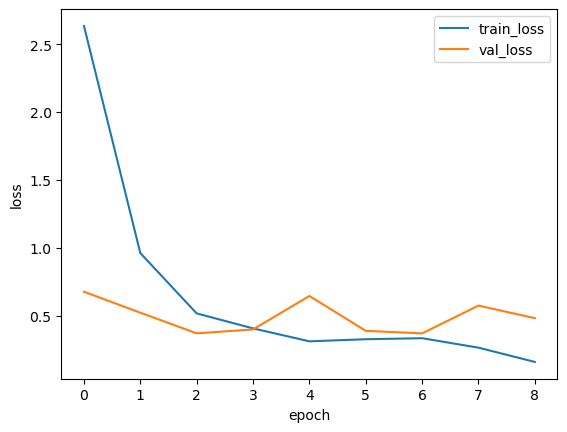

In [76]:
train_history3 = pd.DataFrame(history3.history)
train_history3['epoch'] = history3.epoch

# plot train loss + validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history3)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history3)
# add legends
plt.legend(labels = ['train_loss', 'val_loss'])

In [78]:
test_loss3, test_acc3 = model3.evaluate(val_data, verbose = 0)
print(f' The test loss = {test_loss3:.2f} and test accuracy = {test_acc3:.2f}')

 The test loss = 0.48 and test accuracy = 0.91


The third convolutional neural network performs better than the first two models, but it overfits.
The test loss is significantly lower than the first two models. Test accuracy increased from around 0.70 to 0.91.

Training loss starts at around 3 and slowly decreases near 2 epochs to around 0.5. It then continuously decreases with a negative slope.

Validation loss is a jagged horizontal line. It starts lower than training loss, at about 0.5, but is higher than training loss as the epochs increase.

The decreasing training loss and higher validation loss indicates that the model is overfit.